# Problem statement
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

## Building a simple CNN model

#### **Task 1: Reading the data**

Importing all the important libraries

In [1]:
# Importing the required libraries
import pathlib
import os
import PIL

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD

You are expected to load the data in the Colab environment by mounting the Google Drive. This will allow you to access the files from Google drive through Colab. 

Steps:
1. Upload the dataset in your Google Drive in a separate folder. Avoid spaces in the name of the folder or the zip file.
2. Mount the Google Drive using the code given below.
3. Unzip the file to access images.
4. Check the path for the datasets - train and test.


Note: The code is commented for you to learn and then make edits to execute the command.

In [2]:
## If you are using the data by mounting the google drive, use the following:
from google.colab import drive
drive.mount('/content/gdrive')

## Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [ ]:
# Your GDrive Directory
# !ls /content/gdrive/MyDrive

In [ ]:
# Unzipping the files
# To do: Update the folder name and file name
# !ls /content/gdrive/"My Drive"/Projects/MelanomaDetectionAssignment/"Skin cancer ISIC The International Skin Imaging Collaboration"/

Check the path mentioned in the output: `Skin cancer ISIC The International Skin Imaging Collaboration`

Provide the path for train and test images using pathlib library.

In [27]:
# Defining the path for train and test images
## To do: Update the paths of the train and test dataset
base_dir= '/content/gdrive/MyDrive/Projects/MelanomaDetectionAssignment/Skin cancer ISIC The International Skin Imaging Collaboration'
data_dir_train = pathlib.Path(base_dir+"/Train")
data_dir_test = pathlib.Path(base_dir+'/Test')

Check whether the data has been extracted successfully.

In [4]:
# Train and test images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train images:\t", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test images:\t", image_count_test)

Train images:	 2239
Test images:	 118


#### **Task 2: Loading the images using keras.preprocessing**

The images are still not loaded in the Colab environment. We have extracted them from the zip file. Now, you are expected to load them in the Colab notebook using the `preprocessing` attribute.

Let's load these images off disk using the helpful image_dataset_from_directory utility. You can refer to the following [link](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) to know more about the function. You can even refer to the additional notebooks on the page to check how the variables are defined.



Defining the parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Divide the training set into 2 parts: 
*   80% for training 
*   20% for validation



In [6]:
## Write your code for train dataset here.
## Note: Use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note: Make sure you resize your images to the size: img_height*img_width, while specifying the variable

train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,
                                                               batch_size=batch_size,
                                                               validation_split=0.2,
                                                               subset="training",
                                                               image_size=(img_height,img_width),
                                                              #  label_mode='categorical',
                                                               seed=123)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your code for validation dataset here.
## Note: Use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note: Make sure you resize your images to the size: img_height*img_width, while specifying the variable

val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,
                                                               batch_size=batch_size,
                                                               validation_split=0.2,
                                                               subset="validation",
                                                               image_size=(img_height,img_width),
                                                              #  label_mode='categorical'
                                                               seed=123)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the 'class_names' attribute associated with the training and validation datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### **Task 3: Visualize the data**

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

Write the code to visualize one instance of all the nine classes present in the dataset

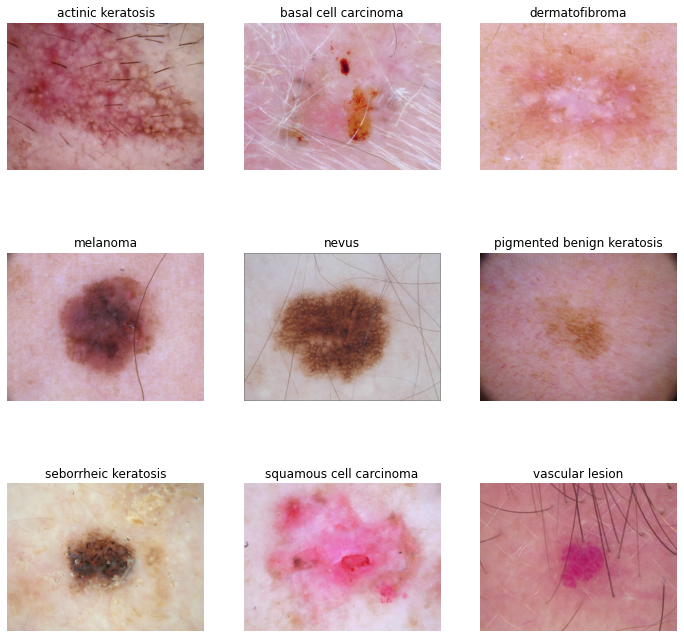

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(12, 12))
for i in range(len(class_names)):
  ax = plt.subplot(3, 3, i + 1)
  image_list = sorted(list(data_dir_train.glob(class_names[i] + '/*.jpg')))
  plt.imshow(mpimg.imread(image_list[0]))                    # Displaying one instance of all 9 classes.
  plt.title(class_names[i])
  plt.axis("off")

plt.show()

#### Configure the dataset for performance
Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Task 4: Create the model**
Create a CNN model, which can accurately detect 9 classes present in the dataset. 


*   Note: The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`. Use `layers.experimental.preprocessing.Rescaling` for this purpose.

In [11]:
num_classes = len(class_names)

model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))])

# 1st convolutional layer
model.add(Conv2D(32, kernel_size= (3, 3), activation='relu', padding = 'Same', strides= 2))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd convolutional layer
model.add(Conv2D(64, kernel_size= (3, 3), activation='relu', padding = 'Same', strides= 2))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of the pooling layer to give us a long vector and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

#### **Question**: 
Explain the following elements associated with the problem:
1.   Selection of stride value (Reason for using a high/low value)
2.   Padding strategy used (Same/Valid)

1. Stride refers to the number of pixels by which we slide over the filter matrix over the input matrix. I have used a smaller stride (2) because it would produce a larger feature map, as we have a very less number of samples per class so a larger feature map would help us in exracting more information.

2. As we know that the size of the output gets reduced after each convolution. In Padding we add extra rows and coumns to the outer dimension of the image.
'Valid' padding is considered as a no padding. So I have used 'Same' as the padding strategy it helps in output size as same as input size, which helps in increasing the size of the output and preseve the information present in the corners too.

#### **Task 5: Compile the model**
Choose an appropirate optimiser and loss function for model training.

In [12]:
### Choose an appropirate optimiser and loss function
model.compile(optimizer= Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [13]:
## View the summary of all layers
model.summary()

#### Train the model

In [14]:
# The model needs to be trained for 20 epochs
epochs = 20

history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs=epochs
)


Epoch 1/20
56/56 [==============================] - 28s 157ms/step - loss: 2.1831 - accuracy: 0.3092 - val_loss: 1.7193 - val_accuracy: 0.3826
Epoch 2/20
56/56 [==============================] - 4s 63ms/step - loss: 1.5177 - accuracy: 0.4844 - val_loss: 1.4839 - val_accuracy: 0.5056
Epoch 3/20
56/56 [==============================] - 4s 63ms/step - loss: 1.3594 - accuracy: 0.5290 - val_loss: 1.4165 - val_accuracy: 0.5347
Epoch 4/20
56/56 [==============================] - 3s 62ms/step - loss: 1.2265 - accuracy: 0.5731 - val_loss: 1.4047 - val_accuracy: 0.5436
Epoch 5/20
56/56 [==============================] - 3s 62ms/step - loss: 1.1020 - accuracy: 0.6127 - val_loss: 1.3853 - val_accuracy: 0.5391
Epoch 6/20
56/56 [==============================] - 4s 63ms/step - loss: 0.9417 - accuracy: 0.6758 - val_loss: 1.6206 - val_accuracy: 0.5034
Epoch 7/20
56/56 [==============================] - 3s 62ms/step - loss: 0.8709 - accuracy: 0.6959 - val_loss: 1.6394 - val_accuracy: 0.5213
Epoch 8/20

#### Visualizing training results

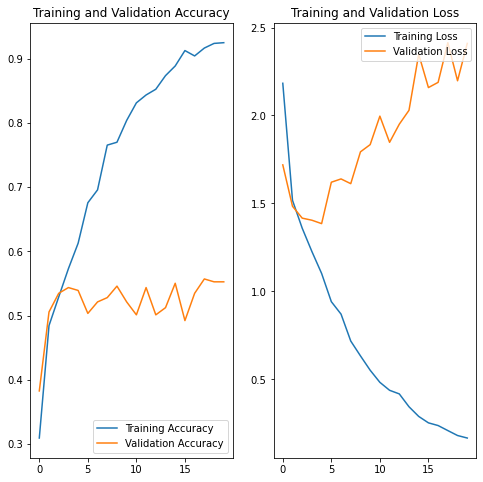

In [ ]:
# Graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Question**:
Write your findings after the model fit, see if there is an evidence of model overfit or underfit

As we can see from the graphs that the model accuracy on the training data is high than that on the validation set, which signfies that our model is "Overfiting". Even the Loss of validation set is very high as compared to that of the training set. 

We can also see that until 4-5 epochs training and validation accuracy both increased. But after that training accuracy keeps on increasing to 92% whereas validation accuracy keeps fluctuating at 50%.

Overfitting usually occurs when we have a small number of training data to feed into a deep learning model, the model sometimes learns from noises or unwanted details to an extent that it negatively impacts the performance of the model on new examples. It means that the model was not able to generalize on the dataset.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [15]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.3, fill_mode='reflect'),
    layers.experimental.preprocessing.RandomZoom(0.2, fill_mode='reflect'),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times

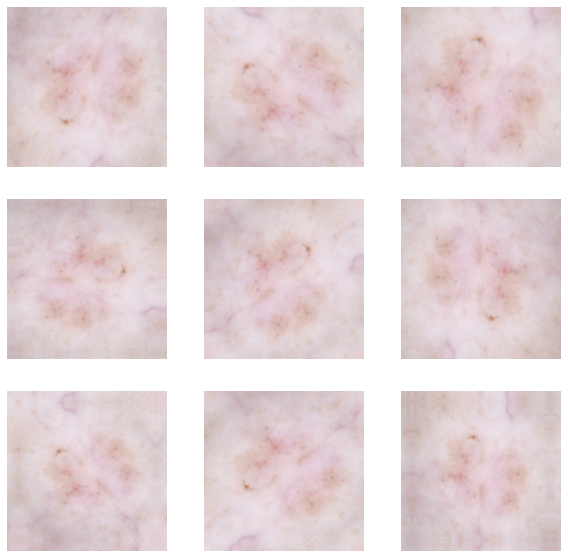

In [17]:
# Visualizing how the augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### **Task 6: Create, compile and train the model**

Model Definition

In [18]:
## You should also include dropouts to tackle with overfitting. (compulsory)
num_classes = 9
model = Sequential()

model.add(data_augmentation)
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))

model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

Compiling the model

In [19]:
model.compile(optimizer = Adam(learning_rate=0.001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

Training the model

In [22]:
# Note: Train your model for 20 epochs
epochs = 20

history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 129s 2s/step - loss: 2.0108 - accuracy: 0.2494 - val_loss: 1.8467 - val_accuracy: 0.3445
Epoch 2/20
56/56 [==============================] - 14s 219ms/step - loss: 1.6574 - accuracy: 0.4007 - val_loss: 1.6084 - val_accuracy: 0.4430
Epoch 3/20
56/56 [==============================] - 14s 216ms/step - loss: 1.5455 - accuracy: 0.4498 - val_loss: 1.4318 - val_accuracy: 0.5481
Epoch 4/20
56/56 [==============================] - 14s 215ms/step - loss: 1.4214 - accuracy: 0.4967 - val_loss: 1.4137 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 14s 220ms/step - loss: 1.3535 - accuracy: 0.5290 - val_loss: 1.4480 - val_accuracy: 0.4810
Epoch 6/20
56/56 [==============================] - 14s 214ms/step - loss: 1.3282 - accuracy: 0.5246 - val_loss: 1.4011 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 14s 219ms/step - loss: 1.3110 - accuracy: 0.5340 - val_loss: 1.4421 - val_accuracy: 0.5056
E

#### Visualizing the results

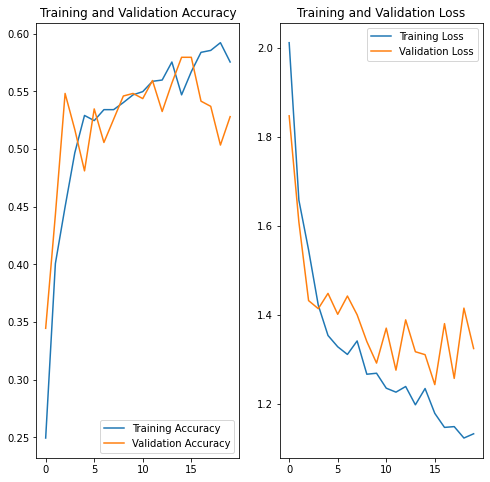

In [23]:
# Graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Question**:
Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Before augmentation was applied we can clearly see that their was a huge difference between the train and validation accuracy of the model, which implies that the model is overfitting. 
But after applying augmentation we can see that the gap between train and validation accuracy as well as the loss have reduced and they overlap for most of the part.

## Distribution in the dataset

**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<br>

#### **Task 7: Find the distribution of classes in the training dataset.**

In [28]:
df  = []
for i in class_names:
  path_list = [x for x in data_dir_train.glob(i+'/*.jpg')]
  df.append(len(path_list))
df = pd.DataFrame(list(zip(class_names,df)),columns=["class","counts"])
print(df)

                        class  counts
0           actinic keratosis     114
1        basal cell carcinoma     376
2              dermatofibroma      95
3                    melanoma     438
4                       nevus     357
5  pigmented benign keratosis     462
6        seborrheic keratosis      77
7     squamous cell carcinoma     181
8             vascular lesion     139


#### **Questions:**  
 - Which class has the least number of samples?
 - Which classes dominate the data in terms proportionate number of samples?


- seborrheic keratosis has the least number of samples
- pigmented benign keratosis and melanoma dominates the data in terms of proportionate number of sample.

#### **Task 8: Rectifying the class imbalance**
You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
# Provide the path for the training dataset
path_to_training_dataset= base_dir+'/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)
    ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Projects/MelanomaDetectionAssignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6794561D90>: 100%|██████████| 500/500 [00:21<00:00, 23.44 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Projects/MelanomaDetectionAssignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6793458550>: 100%|██████████| 500/500 [00:27<00:00, 18.07 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Projects/MelanomaDetectionAssignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6810F82E50>: 100%|██████████| 500/500 [00:24<00:00, 20.63 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Projects/MelanomaDetectionAssignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F67934F8F90>: 100%|██████████| 500/500 [01:45<00:00,  4.74 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Projects/MelanomaDetectionAssignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F67933D37D0>: 100%|██████████| 500/500 [01:42<00:00,  4.88 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Projects/MelanomaDetectionAssignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6810F8B350>: 100%|██████████| 500/500 [00:20<00:00, 24.64 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Projects/MelanomaDetectionAssignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6794561A10>: 100%|██████████| 500/500 [00:45<00:00, 10.89 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Projects/MelanomaDetectionAssignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F67934B6D50>: 100%|██████████| 500/500 [00:20<00:00, 23.81 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Projects/MelanomaDetectionAssignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F67934D8FD0>: 100%|██████████| 500/500 [00:20<00:00, 24.08 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [30]:
# Count of images under each class after addition
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
# path_list

In [32]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
# lesion_list

In [33]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list_new

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new

In [35]:
original_dict = dict(zip(path_list, lesion_list))
original_df= pd.DataFrame(list(original_dict.items()),columns = ['Path','Label'])

In [36]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [37]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [38]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### **Task 9: Repeating the steps for balanced augmented data**

In [39]:
batch_size = 32
img_height = 180
img_width = 180

**Create a training dataset**

In [40]:
# Provide the path here
data_dir_train= base_dir+'/Train'

# Provide the subset value here
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**Create a validation dataset**

In [41]:
# Provide the subset value here
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Create your model (make sure to include normalization)**

In [42]:
model = Sequential()  ## creating and instance of Sequential

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

**Compile your model (Choose optimizer and loss function appropriately)**

In [43]:
model.compile(optimizer= SGD(learning_rate= 0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

**Train your model**

In [44]:
# Note: Train your model for 30 epochs
epochs = 30
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs
                   ) 

Epoch 1/30
169/169 [==============================] - 41s 227ms/step - loss: 1.9923 - accuracy: 0.2862 - val_loss: 2.2164 - val_accuracy: 0.1062
Epoch 2/30
169/169 [==============================] - 38s 221ms/step - loss: 1.5861 - accuracy: 0.4151 - val_loss: 2.1049 - val_accuracy: 0.1774
Epoch 3/30
169/169 [==============================] - 38s 219ms/step - loss: 1.4692 - accuracy: 0.4598 - val_loss: 1.5012 - val_accuracy: 0.4892
Epoch 4/30
169/169 [==============================] - 39s 221ms/step - loss: 1.3904 - accuracy: 0.4842 - val_loss: 1.2426 - val_accuracy: 0.5791
Epoch 5/30
169/169 [==============================] - 40s 229ms/step - loss: 1.3327 - accuracy: 0.5054 - val_loss: 1.1606 - val_accuracy: 0.5627
Epoch 6/30
169/169 [==============================] - 41s 237ms/step - loss: 1.2697 - accuracy: 0.5321 - val_loss: 1.1105 - val_accuracy: 0.5999
Epoch 7/30
169/169 [==============================] - 40s 232ms/step - loss: 1.1957 - accuracy: 0.5584 - val_loss: 1.0591 - val_ac

**Visualize the model results**

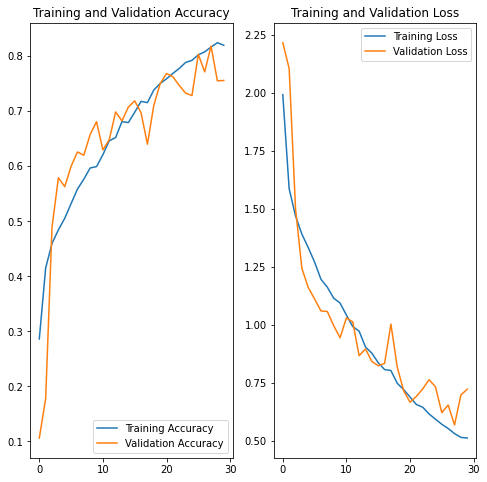

In [45]:
# Graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Task 10: Analyzing the results** 


#### **Question:**
- Did you get rid of underfitting/overfitting from the model? 
- Did class rebalance help in the process?


Introducing Regularization in the form of Batch Normalization and Dropout has helped in overcoming overfitting/underfitting of the model which we can clearly see in the graph above that the gap between the train and validation accuracy is quite less as well as the validation loss has reduced. This is because regularization helps in reducing the noise from the data and making the data flowing between the intermediate layers of the model more standardised. 

Data Augmentation definately helped to handle class rebalance by introducing new samples to each class. But we could also try making total number of samples for all classes equal (For Example: all the 9 classes can have 400 samples each). Beacuase if we see the currently rebalacing even after adding 500 samples to each class 'seborrheic keratosis' has relatively less number of samples as compared to 'pigmented benign keratosis'.